Lab04

Libs
read in necessary libs

In [194]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model._stochastic_gradient import SGDRegressor
from sklearn.ensemble import VotingRegressor
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import MinMaxScaler
import math


<h2>Project 1</h2>
<h3>Project 1 (a) Data loading, visualisation, and cleaning</h3>

<p>

1. In this part we first read in the data set.

2. Then a function <code>cleaning(set)</code> was given to perform data cleaning, the function reads a dataframe as input, and outputs a cleaned data frame.

    During the data cleaning, 3 cols were dropped: SLUMP(cm), FLOW(cm) due to they are not the value we're going to use as required by the labsheet, 

    Col 'No' was also dropped because it only stands for the  order of data, and will not contain any information useful to the training.

    <code>Minmax scaler</code> was also used in data cleaning procdure to rescale the feature of the data. The label of the data, that is, the col 'Compressive Strength' was not rescaled because we want the predict value can be viewed directly.

3. After cleaning, <code>hist()</code> was used for visualizing the data, it shows that the data has 7 features and was not centered.
</p>

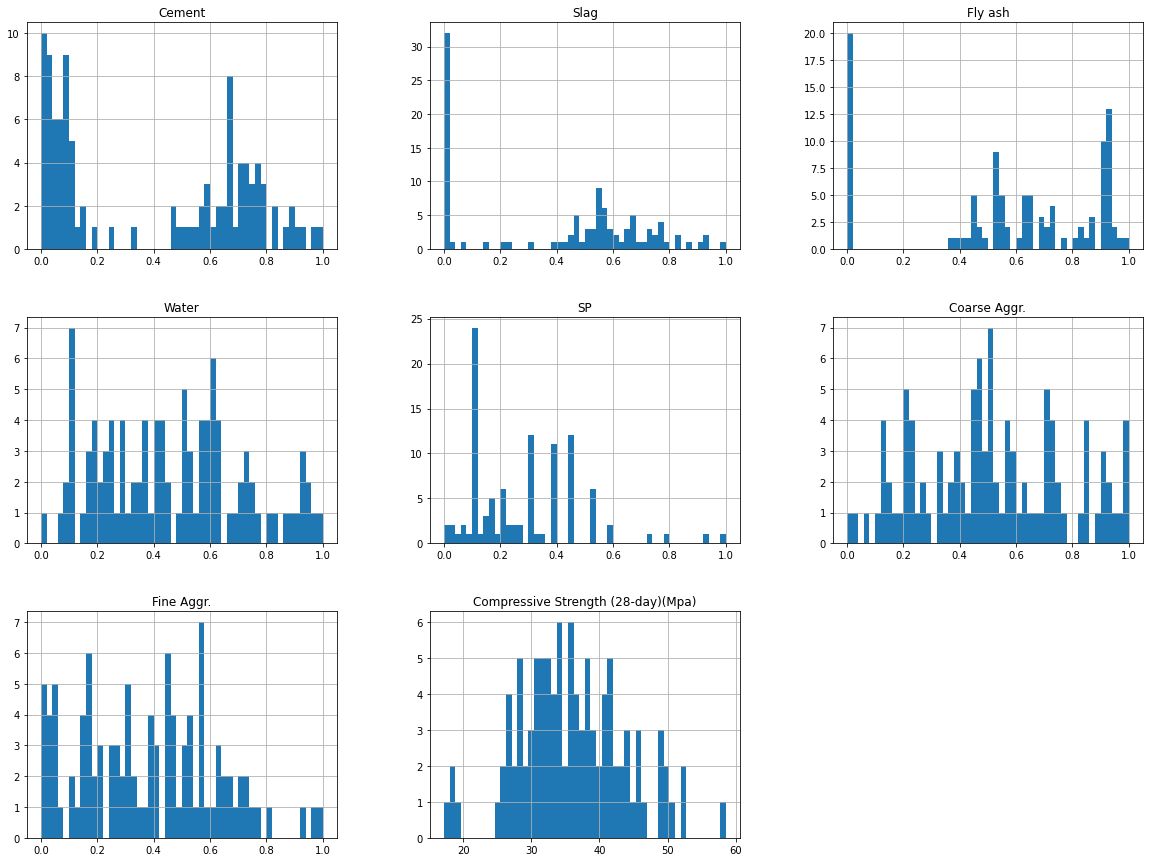

In [195]:
dataSet=pd.read_csv('./slump_test.data')
# perform data preprocessing.
# since SLUMP(cm) and FLOW(cm) are required to be removed by the labsheet, so removing these two cols from dataframe.
# col 'No' only stands for the  order of data, it will not contain any information useful to the training, so remove it.
def cleaning(set):
    set.dropna(inplace = True)
    temp_feature=set.drop(['SLUMP(cm)','FLOW(cm)','No',"Compressive Strength (28-day)(Mpa)"],axis=1)
    temp_label=set["Compressive Strength (28-day)(Mpa)"]

    # rescale the deature
    scaler=MinMaxScaler(feature_range=(0,1))
    scaler.fit(temp_feature)
    temp_feature=scaler.transform(temp_feature)
    temp_feature=pd.DataFrame(temp_feature)
    temp_feature.columns=["Cement","Slag","Fly ash","Water","SP","Coarse Aggr.","Fine Aggr."]

    # concat feature and label, then return
    result_set=pd.concat([temp_feature,temp_label],axis=1)
    return result_set

dataSet=cleaning(dataSet)
dataSet.hist(bins=50,figsize=(20,15))
plt.show()

<h3>Project1 (b) Voting Regressor - set up, training and prediction</h3>

<p>

1. In this part we first split the data to train set and test set with ratio 80 : 20 randomly using <code>train_test_split()</code>

2. Then we create 3 base estimators: svm regressor, linear regressor, sgd regressor.

   1. For svm regressor, we use kernel reb and gamma auto, regularization parameter C was set to 20 cause default value makes the predict underfitting while too high the value make the predict over fitting.

   2. For linear regressor, fit_intercept was set true for a better accuracy. other parameter was not set because setting the parameters in linear regressor only applies data prapretion to the set, which we've done earlier.

   3. For sgd regressor, we set loss using squared_error and penalty l2 for a better accuracy.

3. After creating the 3 base estimators, we use base estimators to form a voting regressor, all 4 regressors were trained in this part.
</p>


In [196]:
# perform train-test set split
# split to 20% testing and 80% training

feature=dataSet.drop(["Compressive Strength (28-day)(Mpa)"],axis=1)
label=dataSet["Compressive Strength (28-day)(Mpa)"]
feature_train,feature_test,label_train,label_test = train_test_split(feature, label, test_size=0.2, random_state=0)

# building regressors

svr_reg = SVR(kernel='rbf',gamma='auto',C=20)
lnr_reg=LinearRegression(fit_intercept=True)
sgd_reg = SGDRegressor(loss='squared_error', penalty='l2')
voting_reg=VotingRegressor(
    [('svr',svr_reg),('lnr',lnr_reg),('sgd',sgd_reg)]
)

# train regressors

for reg in(svr_reg,lnr_reg,sgd_reg,voting_reg):
    reg.fit(feature_train,label_train)

<h3>Project 1 (c) Voting Regressor - results and plots</h3>

<p>

1. In this part we first using each regressor to predict the test set, then illustrate the predicted values versus the ground truth values of all the test instances.

    After that we caculated the RMSEs for each regressor and draw a bar diagram to compare them

2. From the result we can find that SVR and Linear regressor has a close RMSEs, while SGD has a much higher RMSE. That is because SGD regressor requires a large training set for the best performance. 

    Voting regressor's RMSE is more close to the lower bound of RMSEs, that is because the voting regressor takes all 3 base regressors' predict result to form its own, 2 of the 3 base regressors, SVR and Linear have a close low RMSEs values, so the Voting regressors should be lower instead of higher as SGD regressor is.
</p>

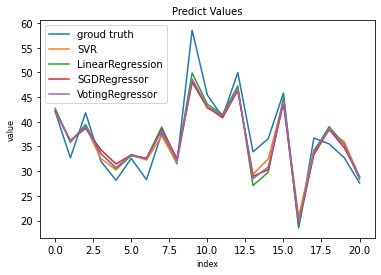

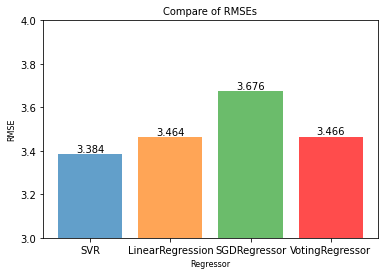

In [197]:
# record the predict results
rmselist=[]
nameList=[]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']

# illustrate the predicted values versus the ground truth values of all the test instances
indexList = np.arange(0,len(label_test),1,int)
plt.plot(indexList, label_test, label="groud truth")

for reg in(svr_reg,lnr_reg,sgd_reg,voting_reg):
    label_pred=reg.predict(feature_test)
    rmse = np.sqrt(metrics.mean_squared_error(label_test, label_pred))
    rmselist.append(rmse)
    nameList.append(reg.__class__.__name__)
    plt.plot(indexList, label_pred, label=reg.__class__.__name__)

plt.legend(loc='best')
plt.xlabel("index", fontdict={'size': 8})
plt.ylabel("value", fontdict={'size': 8})
plt.title("Predict Values", fontdict={'size': 10})
plt.show()

# compare RMSEs of each regressor
plt.ylim(3, 4)
bars=plt.bar(nameList, rmselist,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Regressor", fontdict={'size': 8})
plt.ylabel("RMSE", fontdict={'size': 8})
plt.title("Compare of RMSEs", fontdict={'size': 10})
plt.show()


<h2>Project 2</h2>
<h3>Project 2 (a) Data loading, visualisation, and preparation</h3>

1. In this part we read in the data, given each col a col name from the .name file.

2. Then we perform basic data cleaning, including omit NAs and transforming string type col to int type col.

3. After that we use <code>hist()</code> to have an overview of the data frame. from the diagram we can find the data has 8 features, both features are quite centered except 'Sex', the range of each features are close, so there's no need to rescale features. The label 'Rings' is of to type int, so what we predict should be an integer too.

    By observing the set in col 'Rings', we can find the most common Rings value is 10 and about 700 of instances are valued in 10, so we can later set the max_leaf_nodes as 600, because train set we used in the regressor only contains 85% of the data, 700*85% = 595

4. In the end, we split the data set into train set and test set with ratio 85 : 15 using <code>train_test_split()</code>

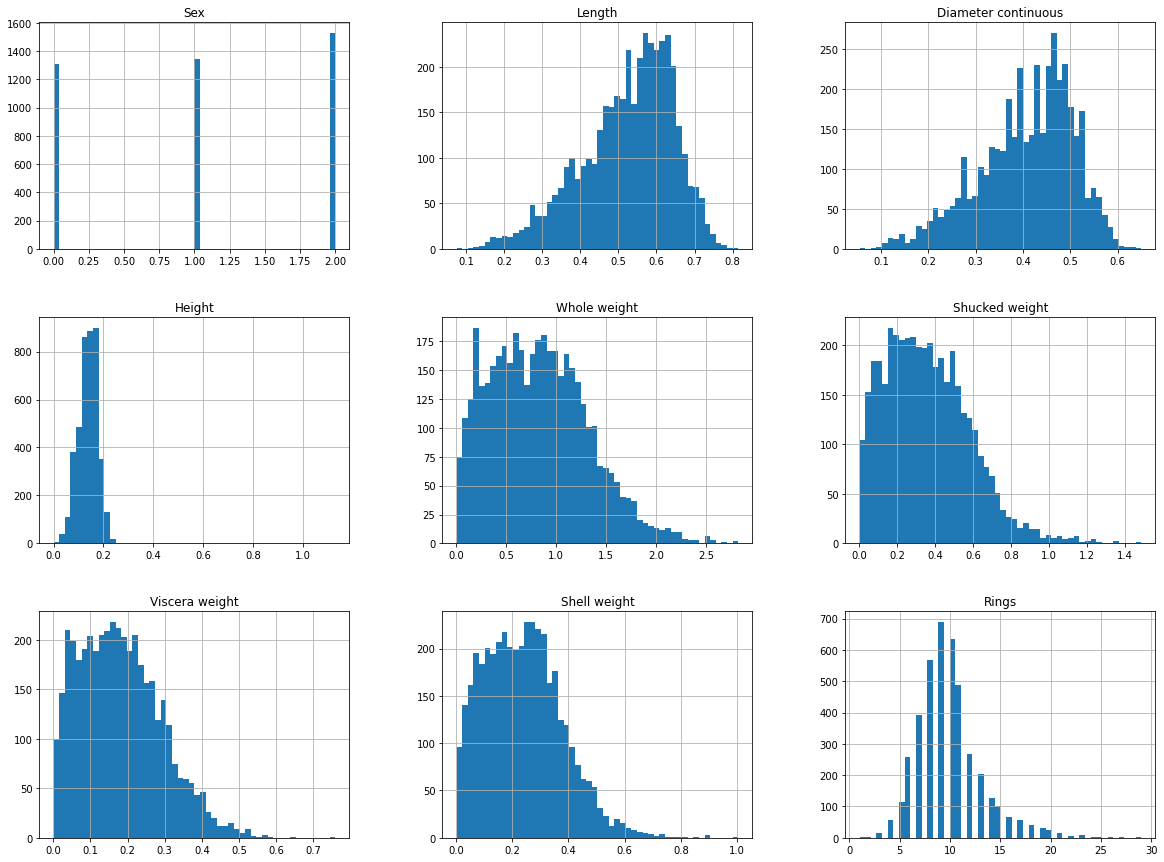

In [198]:
# read in the data
dataSet=pd.read_csv('./abalone.data')
# since the data lacks of col names, apply col name to the data frame
dataSet.columns=["Sex","Length","Diameter continuous","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"]

# data cleaning
dataSet.dropna(inplace = True)
# Sex was a col with type string, and not suppported by regressors as a feature
# Using ordinal Encoder to change col 'Sex' from string to int
ordinal_encoder=OrdinalEncoder()
temp=dataSet[['Sex']]
temp2=ordinal_encoder.fit_transform(temp)
dataSet['Sex']=temp2

# visualising the data
dataSet.hist(bins=50,figsize=(20,15))
plt.show()


# split the set to feature and label
# using 15% of the set for testing and 85% for training as required in the labsheet
feature=dataSet.drop(["Rings"],axis=1)
label=dataSet["Rings"]
feature_train,feature_test,label_train,label_test = train_test_split(feature, label, test_size=0.15, random_state=0)

In [199]:
# define function roundArray to turn a array from double to int
# used for later process to the predict value data
def roundArray(arr):
    for i in range(0,len(arr)):
        arr[i]=round(arr[i])

<h3>Project 2 (b) RF Regressor 1 on full-dimensional data</h3>

1. in this part we implemented a rf regressor using n_estimators=500, using grid search we can find the best max_feature to the set should be 'sqrt', and best min_impurity_decrease should be 0, criterion used should be 'absolute_error'

    What's more, by observing the set in col 'Rings', we can find the most common Rings value is 10 and about 700 of instances are valued in 10, so we can set the max_leaf_nodes as 600, because train set we used in the regressor only contains 85% of the data, 700*85% = 595
    
    N_jobs is set -1 to for a quicker fitting.

2. Then we trained the regressor using training set, test it and reports its RMSE


In [200]:
# grid search
# you don't need to run this
'''
bestRMSE=10000
bestParameters={}
for max_features in ["auto","sqrt","log2", None]:
    for min_impurity_decrease in [0,0.01,0.1]:
        for criterion in ["squared_error","absolute_error"]:
            rf_reg = RandomForestRegressor(n_estimators=500,random_state=0,max_features=max_features,criterion=criterion,min_impurity_decrease=min_impurity_decrease,n_jobs=-1)
            rf_reg.fit(feature_train,label_train)
            label_pred=rf_reg.predict(feature_test)
            rmse=np.sqrt(metrics.mean_squared_error(label_test, label_pred))
            if rmse<bestRMSE:
                bestRMSE=rmse
                bestParameters={'max_features':max_features,'criterion':criterion,'min_impurity_decrease':min_impurity_decrease}
print(bestRMSE)
print(bestParameters)
'''

'\nbestRMSE=10000\nbestParameters={}\nfor max_features in ["auto","sqrt","log2", None]:\n    for min_impurity_decrease in [0,0.01,0.1]:\n        for criterion in ["squared_error","absolute_error"]:\n            rf_reg = RandomForestRegressor(n_estimators=500,random_state=0,max_features=max_features,criterion=criterion,min_impurity_decrease=min_impurity_decrease,n_jobs=-1)\n            rf_reg.fit(feature_train,label_train)\n            label_pred=rf_reg.predict(feature_test)\n            rmse=np.sqrt(metrics.mean_squared_error(label_test, label_pred))\n            if rmse<bestRMSE:\n                bestRMSE=rmse\n                bestParameters={\'max_features\':max_features,\'criterion\':criterion,\'min_impurity_decrease\':min_impurity_decrease}\nprint(bestRMSE)\nprint(bestParameters)\n'

In [201]:
# building random forest regressor
# train the regressor
rf_reg = RandomForestRegressor(n_estimators=500,random_state=0,max_leaf_nodes=600,max_features='sqrt',criterion='absolute_error',min_impurity_decrease=0,n_jobs=-1)
rf_reg.fit(feature_train,label_train)
label_pred=rf_reg.predict(feature_test)
roundArray(label_pred)
print(rf_reg.__class__.__name__+' RMSE is: '+str(np.sqrt(metrics.mean_squared_error(label_test, label_pred))))

RandomForestRegressor RMSE is: 2.0075614636426526


<h3>Project 2 (c) Feature importance & dimensionality reduction</h3>

1. In this part we use <code>SelectFromModel()</code> to select low correlation features from the regressor model, we set prefit as true cause the regressor is fitted previously and threshold 0.05 as required in the labsheet

2. After that we get a list using <code>selector.get_support()</code> containing which col should be removed and which should be retianed, it shows that the col 'Sex' has a correlation lower then 0.05 to the model, so we removed this col.
Before removing, there's 8 cols in the feature, after removing, 7 cols were kept

In [202]:
# apply selector to selector cols with high correlation with the regressor trained previously
# using threshold 0.05
# drop the cols less then threshold

selector=SelectFromModel(rf_reg,prefit=True,threshold=0.05)
print("Before reduction, cols number is: ",feature_train.shape[1])
print("Cols are: ",feature_train.columns.values)
print("Keep the feature?",'\n',feature_train.columns.values,'\n',selector.get_support())
reduced_feature_train=feature_train[feature_train.columns[selector.get_support()]]
reduced_feature_test=feature_test[feature_test.columns[selector.get_support()]]
print("After reduction, cols number is: ",reduced_feature_train.shape[1])
print("Cols are: ",reduced_feature_train.columns.values)


Before reduction, cols number is:  8
Cols are:  ['Sex' 'Length' 'Diameter continuous' 'Height' 'Whole weight'
 'Shucked weight' 'Viscera weight' 'Shell weight']
Keep the feature? 
 ['Sex' 'Length' 'Diameter continuous' 'Height' 'Whole weight'
 'Shucked weight' 'Viscera weight' 'Shell weight'] 
 [False  True  True  True  True  True  True  True]
After reduction, cols number is:  7
Cols are:  ['Length' 'Diameter continuous' 'Height' 'Whole weight' 'Shucked weight'
 'Viscera weight' 'Shell weight']


<h3>Project 2 (d) RF Regressor 2 on reduced-dimensional data and comparison</h3>

1. In this part, we'll train the regressor again using the reduced training set after selection. The hyperparameters value left the same as what they are in regressor 1.

2. After training the regressor, a function <code>caculateMSE()</code> was defined to caculate MSE of each instances, it takes the predict set and test set as input, returns a set with MSE values for each prediction.

    A plot diagram was draw using the data obtianed from <code>caculateMSE()</code> function, and it shows that the higher the ring value is, is higher the MSE is.

3. In the end, we compare the RMSEs of regressor 1 and regressor 2, a bar diagram was darw for a better view.




In [203]:
# train the regressor again
rf_reg2 = RandomForestRegressor(n_estimators=500,random_state=0,max_leaf_nodes=600,max_features='sqrt',criterion='absolute_error',min_impurity_decrease=0,n_jobs=-1)
rf_reg2.fit(reduced_feature_train,label_train)
label_pred2=rf_reg2.predict(reduced_feature_test)
print(rf_reg2.__class__.__name__+' RMSE is: '+str(np.sqrt(metrics.mean_squared_error(label_test, label_pred2))))

RandomForestRegressor RMSE is: 2.0197476665077834


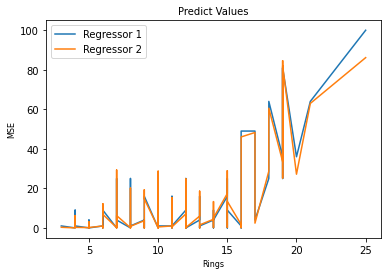

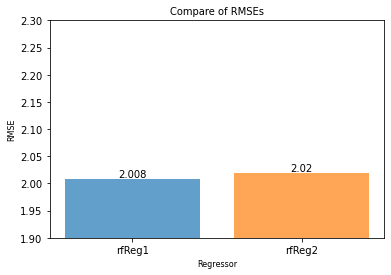

In [204]:
# define function to caculate MSE for each instance
def caculateMSE(pred,test):
    arr_mse=[]
    pred=np.array(pred)
    test=np.array(test)
    for index in range(0,len(test)):
        arr_mse.append(math.pow(test[index]-pred[index],2))
    return np.array(arr_mse)

# caculating MSE
label_test_copy=np.array(label_test)
label_pred_error=caculateMSE(label_pred,label_test_copy)
label_pred_error2=caculateMSE(label_pred2,label_test_copy)

arrIndex = np.array(label_test).argsort()
label_pred_error = label_pred_error[arrIndex]
label_pred_error2 = label_pred_error2[arrIndex]
label_test_copy = label_test_copy[arrIndex]

# draw MSE diagram
plt.plot(label_test_copy, label_pred_error, label="Regressor 1")
plt.plot(label_test_copy, label_pred_error2, label="Regressor 2")
plt.legend(loc='best')
plt.xlabel("Rings", fontdict={'size': 8})
plt.ylabel("MSE", fontdict={'size': 8})
plt.title("Predict Values", fontdict={'size': 10})
plt.show()


# draw RMSE diagram
rfReg1_rmse=np.sqrt(metrics.mean_squared_error(label_test, label_pred))
rfReg2_rmse=np.sqrt(metrics.mean_squared_error(label_test, label_pred2))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
plt.ylim(1.9, 2.3)
bars=plt.bar(['rfReg1', 'rfReg2'], [rfReg1_rmse,rfReg2_rmse],color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Regressor", fontdict={'size': 8})
plt.ylabel("RMSE", fontdict={'size': 8})
plt.title("Compare of RMSEs", fontdict={'size': 10})
plt.show()



<h3>Project 2 (e) Bagging Regressor</h3>

1. In this part we're going to train a bagging regressor, using SVM regressor with kernel rbf, gamma auto and C = 20.

    We set the n_estimators of the bagging regressor as 500 as required in labesheet, and n_jobs = -1 for a quicker fit, other parameters was set the same as the RF regressor 1

2. After training, a diagram of predicted ring values versus the ground truth ring values of all the test instances was illustrated.



In [205]:
# train bagging regressor with n_estimators=500

# training regressor
bag_reg=BaggingRegressor(SVR(kernel='rbf',gamma='auto',C=20),n_estimators=500,n_jobs=-1)
bag_reg.fit(feature_train,label_train)
bag_label_pred=bag_reg.predict(feature_test)






RandomForestRegressor RMSE is: 2.0585527813075446


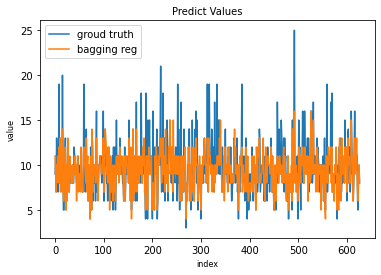

In [206]:
# illustrate a diagram of predicted ring values versus the ground truth ring values of all the test instances
roundArray(bag_label_pred)
print(rf_reg2.__class__.__name__+' RMSE is: '+str(np.sqrt(metrics.mean_squared_error(label_test, bag_label_pred))))
indexList = np.arange(0,len(label_test),1,int)
plt.plot(indexList, label_test, label="groud truth")
plt.plot(indexList, bag_label_pred, label="bagging reg")
plt.legend(loc='best')
plt.xlabel("index", fontdict={'size': 8})
plt.ylabel("value", fontdict={'size': 8})
plt.title("Predict Values", fontdict={'size': 10})
plt.show()

<h3>Project 2 (f) Comparison between RF Regressor 1 and Bagging Regressor</h3>

1. In this part, we will compare the performance of RF regressor 1 and bagging regressor

    1. From the MSE diagram we draw, we can find that bagging regressor has a lower MSE in the upper and lower ends of the data.

    2. In the middile of the data, the RF Regressor 1 has a lower MSE.

    3. The bagging regressor's RMSE is slightly higher then the RF regreoosr 1.

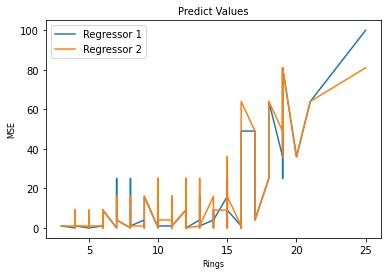

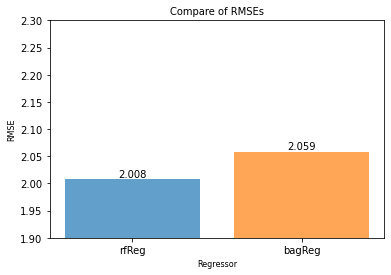

In [207]:
# caculating MSE
label_test_copy=np.array(label_test)
label_pred_error=caculateMSE(label_pred,label_test_copy)
label_pred_error2=caculateMSE(bag_label_pred,label_test_copy)

arrIndex = np.array(label_test).argsort()
label_pred_error = label_pred_error[arrIndex]
label_pred_error2 = label_pred_error2[arrIndex]
label_test_copy = label_test_copy[arrIndex]

# draw MSE diagram
plt.plot(label_test_copy, label_pred_error, label="Regressor 1")
plt.plot(label_test_copy, label_pred_error2, label="Regressor 2")
plt.legend(loc='best')
plt.xlabel("Rings", fontdict={'size': 8})
plt.ylabel("MSE", fontdict={'size': 8})
plt.title("Predict Values", fontdict={'size': 10})
plt.show()



# draw RMSE diagram
rfReg1_rmse=np.sqrt(metrics.mean_squared_error(label_test, label_pred))
rfReg2_rmse=np.sqrt(metrics.mean_squared_error(label_test, bag_label_pred))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
plt.ylim(1.9, 2.3)
bars=plt.bar(['rfReg', 'bagReg'], [rfReg1_rmse,rfReg2_rmse],color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Regressor", fontdict={'size': 8})
plt.ylabel("RMSE", fontdict={'size': 8})
plt.title("Compare of RMSEs", fontdict={'size': 10})
plt.show()